It is necessary to train the model to classify comments into positive and negative. At your disposal is a dataset with markup on the toxicity of edits.

# 1. Preparation

I install the tensorflow libraries and the necessary components of the required version.

In [1]:
pip show tensorflow

Name: tensorflow
Version: 2.1.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.7/site-packages
Requires: grpcio, termcolor, wheel, keras-preprocessing, opt-einsum, scipy, google-pasta, protobuf, six, tensorboard, wrapt, gast, numpy, absl-py, astor, keras-applications, tensorflow-estimator
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install -q --no-deps tensorflow-addons~=0.8.3

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip uninstall tensorflow protobuf -yes


Usage:   
  /opt/conda/bin/python -m pip uninstall [options] <package> ...
  /opt/conda/bin/python -m pip uninstall [options] -r <requirements file> ...

no such option: -e
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install typeguard

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import nltk
import spacy
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from sklearn.metrics import f1_score
from tensorflow import argmax as tf_argmax
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import utils
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegressionCV
import numpy as np


[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import tensorflow_addons as tfa

In [3]:
data = pd.read_csv('/datasets/toxic_comments.csv')
data

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


The data read normally, there are no gaps.

In [5]:
print('Percent class "1":', len(data.loc[data['toxic']==1])/len(data)*100)

Процент класса "1": 10.167887648758233


There is an imbalance in the data.

In [6]:
data['text'] = data['text'].str.lower()#convert words to lower case
data.head(10).values#see how the algorithm worked

array([["explanation\nwhy the edits made under my username hardcore metallica fan were reverted? they weren't vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.89.205.38.27",
        0],
       ["d'aww! he matches this background colour i'm seemingly stuck with. thanks.  (talk) 21:51, january 11, 2016 (utc)",
        0],
       ["hey man, i'm really not trying to edit war. it's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. he seems to care more about the formatting than the actual info.",
        0],
       ['"\nmore\ni can\'t make any real suggestions on improvement - i wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -i think the references may need tidying so that they are all in the exact same format ie date format etc. i can do that later on, if no-one else do

In [7]:
#I check how the algorithm for filtering unnecessary characters will work
" ".join(re.sub(r'[^a-z!? ]', ' ', "d'aww! he matches this background colour i'm seemingly stuck with. thanks.  (talk) 21:51, january 11, 2016 (utc)").split()) 

'd aww! he matches this background colour i m seemingly stuck with thanks talk january utc'

In [8]:
def lemmatize(text):#function for lemmatization of lines of texts
    lemmatizer = WordNetLemmatizer()
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

In [9]:
lemmatize(data.loc[0,'text'])#check how the function works

"explanation why the edits made under my username hardcore metallica fan were reverted ? they were n't vandalism , just closure on some gas after i voted at new york doll fac . and please do n't remove the template from the talk page since i 'm retired now.89.205.38.27"

In [10]:
data.loc[0,'text']#compare

"explanation\nwhy the edits made under my username hardcore metallica fan were reverted? they weren't vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.89.205.38.27"

In [11]:
new_date = []# pushing lemmatized strings onto the stack
for i in data['text'].values:
    d = lemmatize(i)
    new_date.append(d)
df = pd.DataFrame(new_date, columns = ['text'])#save data to dataframe

In [12]:
df.head().values#checking

array([["explanation why the edits made under my username hardcore metallica fan were reverted ? they were n't vandalism , just closure on some gas after i voted at new york doll fac . and please do n't remove the template from the talk page since i 'm retired now.89.205.38.27"],
       ["d'aww ! he match this background colour i 'm seemingly stuck with . thanks . ( talk ) 21:51 , january 11 , 2016 ( utc )"],
       ["hey man , i 'm really not trying to edit war . it 's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page . he seems to care more about the formatting than the actual info ."],
       ["`` more i ca n't make any real suggestion on improvement - i wondered if the section statistic should be later on , or a subsection of `` '' type of accident '' '' -i think the reference may need tidying so that they are all in the exact same format ie date format etc . i can do that later on , if no-one else doe first - if 

In [13]:
data.head().values#compare

array([["explanation\nwhy the edits made under my username hardcore metallica fan were reverted? they weren't vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.89.205.38.27",
        0],
       ["d'aww! he matches this background colour i'm seemingly stuck with. thanks.  (talk) 21:51, january 11, 2016 (utc)",
        0],
       ["hey man, i'm really not trying to edit war. it's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. he seems to care more about the formatting than the actual info.",
        0],
       ['"\nmore\ni can\'t make any real suggestions on improvement - i wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -i think the references may need tidying so that they are all in the exact same format ie date format etc. i can do that later on, if no-one else do

I noticed the presence of the date / time when the comments were written, for our purposes this is unnecessary information, therefore I delete it.

In [14]:
new_date = []#function for line-by-line removal of redundant information
for i in df['text']:
    d = re.sub(r'january|utc|february|march|april|may|june|july|august|september|october|november|december','',i)
    new_date.append(d)
df = pd.DataFrame(new_date, columns = ['text'])

Remove stop words from the dataset

In [15]:
stop = set(nltk.corpus.stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))#function to remove stop words

In [16]:
df.values#checking

array([["explanation edits made username hardcore metallica fan reverted ? n't vandalism , closure gas voted new york doll fac . please n't remove template talk page since 'm retired now.89.205.38.27"],
       ["d'aww ! match background colour 'm seemingly stuck . thanks . ( talk ) 21:51 , 11 , 2016 ( )"],
       ["hey man , 'm really trying edit war . 's guy constantly removing relevant information talking edits instead talk page . seems care formatting actual info ."],
       ...,
       ['spitzer umm , actual article prostitution ring . - crunch captain .'],
       ['look like wa actually put speedy first version deleted look .'],
       ["`` ... really n't think understand . came idea wa bad right away . kind community go `` '' bad idea '' '' go away , instead helping rewrite them. ``"]],
      dtype=object)

In [17]:
new_date = []#I clean the dataset from unnecessary characters and spaces
for i in df['text']:
    d = [" ".join(re.sub(r"[^a-z!? ]", ' ', str(i)).split())]
    new_date.append(d)
df = pd.DataFrame(new_date, columns = ['text'])

In [18]:
df.head(11).values#checking

array([['explanation edits made username hardcore metallica fan reverted ? n t vandalism closure gas voted new york doll fac please n t remove template talk page since m retired now'],
       ['d aww ! match background colour m seemingly stuck thanks talk'],
       ['hey man m really trying edit war s guy constantly removing relevant information talking edits instead talk page seems care formatting actual info'],
       ['ca n t make real suggestion improvement wondered section statistic later subsection type accident i think reference need tidying exact format ie date format etc later no one else doe first preference formatting style reference want please let know appears backlog article review guess delay reviewer turn s listed relevant form eg wikipedia good article nominations transport'],
       ['sir hero chance remember page s ?'],
       ['congratulation well use tool well talk'],
       ['cocksucker piss around work'],
       ['vandalism matt shirvington article ha reverted pl

In [19]:
df.tail(11).values#compare

array([['editing article without consensus removal cited content without discussion find telling neither courtesy respond proposal k went ahead begin editing article without consensus reached let record note compelled reciprocate action make suggested change jj obviously lack serious knowledge area wa circumventing rr s point answering recent underinformed question ll focus kautilya significantly acquainted topic would understand kakatiyas feudatory eastern chalukya dynasty so question formal royal dynasty began natural question patent nonsense probably one reason previous editor changed old date uncertain wa date given first royal inscription based permanent grant hanumakonda original capital edification fief kakatiyas also suggest refresh knowledge wp civility improve quality current future discussion n t know author s hint ask politely rather first disrespectfully dismissing author demanding c v s book speaks history culture andhra pradesh old state included new state telangana arca

There are words from one letter in the text, I consider them a little informative, although a part is not quite informative, but it turned into just n without a trace, nothing can be done

Since the metric on the logistic regression did not reach 0.75, I decided to keep short words, most of all, a piece of negation and question marks and exclamations carry meaning.

In [21]:
#split the data into samples
df['toxic'] = data['toxic']
train, test = train_test_split(df, test_size=0.25, random_state=42)
features_train = train['text']
target_train = train['toxic']
features_test = test['text']
target_test = test['toxic']

In [22]:
print('Percentage of class "1" of the training sample:', len(target_train.loc[target_train==1])/len(target_train)*100)

Процент класса "1" обучающей выборки: 10.165611056334498


In [23]:
print('Percentage of class "1" of the test sample:', len(target_test.loc[target_test==1])/len(target_test)*100)

Процент класса "1" тестовой выборки: 10.174717368961973


The percentages of classes remained roughly the same.

The code below cannot be loaded as a dataframe or an array, since such an array weighs 116 gigabytes, and training will take a long time, so I will resort to simple tokenization and training of neural networks.

In [24]:
stopwords = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 
tf_idf = count_tf_idf.fit_transform(features_train)


count_tf_idf_ts = TfidfVectorizer(stop_words=stopwords) 
tf_id_ts = count_tf_idf.transform(features_train)

Since it didn’t work to convert words to tf-idf, I tokenize them.

In [26]:
tokenizer = Tokenizer(num_words=20000)#tokinesis words with max word count = 20000
tokenizer.fit_on_texts(features_train)

In [27]:
tokenizer.word_index#checking

{'article': 1,
 's': 2,
 't': 3,
 'n': 4,
 'page': 5,
 'wa': 6,
 'wikipedia': 7,
 'talk': 8,
 'ha': 9,
 'one': 10,
 'would': 11,
 'please': 12,
 'like': 13,
 'see': 14,
 'source': 15,
 'also': 16,
 'think': 17,
 'know': 18,
 'm': 19,
 'time': 20,
 'people': 21,
 'user': 22,
 'doe': 23,
 'edit': 24,
 'use': 25,
 'make': 26,
 'get': 27,
 'image': 28,
 'say': 29,
 'thanks': 30,
 'need': 31,
 'name': 32,
 'even': 33,
 'link': 34,
 'could': 35,
 'good': 36,
 'want': 37,
 'well': 38,
 're': 39,
 'way': 40,
 'information': 41,
 've': 42,
 'deletion': 43,
 'comment': 44,
 'editor': 45,
 'go': 46,
 'section': 47,
 'u': 48,
 'question': 49,
 'help': 50,
 'first': 51,
 'thing': 52,
 'wp': 53,
 'fact': 54,
 'new': 55,
 'work': 56,
 'look': 57,
 'point': 58,
 'editing': 59,
 'edits': 60,
 'discussion': 61,
 'right': 62,
 'thank': 63,
 'made': 64,
 'fuck': 65,
 'many': 66,
 'much': 67,
 'used': 68,
 'really': 69,
 'find': 70,
 'take': 71,
 'deleted': 72,
 'reference': 73,
 'since': 74,
 'read': 75,


In [28]:
#allocate tokens for verification
sequences = tokenizer.texts_to_sequences(features_train)
index = 1
print(features_train[154769])#since the dataset was split in random order, I traced that index 1 in the data itself has index 154769
print(sequences[index])

n t worry think fixed still look cramped
[4, 3, 1314, 17, 1041, 87, 57]


In [29]:
tokenizer.word_index['think']

17

Tokenization was successful. Next, I'll save tokenized data with a 90-word limit.

In [30]:
x_train = pad_sequences(sequences, maxlen=90)

In [31]:
test_sequences = tokenizer.texts_to_sequences(features_test)
x_test = pad_sequences(test_sequences, maxlen=90)

In [32]:
ft = pd.get_dummies(target_train)#transform the answers for the output layer of the neural network = 2
fts = pd.get_dummies(target_test)

Conclusion: the data was preprocessed: stop words, lemmatization were removed, reduced to lower case, uninformative words were removed. The data is ready to train the model.

# 2. Model training

I will train neural networks. The first model will be built on a convolutional neural network.

In [33]:
model_cnn = Sequential()
model_cnn.add(Embedding(20000, 32))#number of words 20000
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(2, activation='softmax'))

In [34]:
model_cnn.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=[tfa.metrics.F1Score(average='macro',num_classes = 2)])#metric f1

In [35]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          640000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 250)         40250     
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32128     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 712,636
Trainable params: 712,636
Non-trainable params: 0
_________________________________________________________________


In [36]:
history_cnn = model_cnn.fit(x_train, 
                            ft, 
                            epochs=1,
                            batch_size=300,
                            validation_split=0.1)

Train on 107710 samples, validate on 11968 samples
107710/107710 [==============================] - 145s 1ms/sample - loss: 0.1948 - f1_score: 0.7583 - val_loss: 0.1150 - val_f1_score: 0.8709


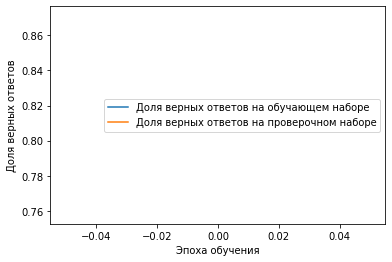

In [37]:
#I build a graph of the quality of training according to the selected metric
plt.plot(history_cnn.history['f1_score'], 
         label='Proportion of correct answers on the training set')
plt.plot(history_cnn.history['val_f1_score'], 
         label='Proportion of correct answers on the test set')
plt.xlabel('Age of Learning')
plt.ylabel('Percentage of correct answers')
plt.legend()
plt.show()

I check the quality of the model.

In [38]:
model_cnn.evaluate(x_test, fts, verbose=1)

39893/39893 [==============================] - 16s 408us/sample - loss: 0.1136 - f1_score: 0.8734


[0.11357230920748655, 0.8734446]

f1 is equal to 0.8734.

I am training an LSTM network.

In [39]:
model_lstm = Sequential()
model_lstm.add(Embedding(20000, 32, input_length=90))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(2, activation='softmax'))
model_lstm.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[tfa.metrics.F1Score(average='macro',num_classes = 2)])

In [40]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 90, 32)            640000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3136      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
Total params: 643,170
Trainable params: 643,170
Non-trainable params: 0
_________________________________________________________________


In [41]:
history_lstm = model_lstm.fit(x_train, 
                              ft, 
                              epochs=2,
                              batch_size=300,
                              validation_split=0.1)

Train on 107710 samples, validate on 11968 samples
Epoch 1/2
107710/107710 [==============================] - 97s 898us/sample - loss: 0.2250 - f1_score: 0.7091 - val_loss: 0.1351 - val_f1_score: 0.8504
Epoch 2/2
107710/107710 [==============================] - 88s 821us/sample - loss: 0.1083 - f1_score: 0.8856 - val_loss: 0.1172 - val_f1_score: 0.8747


Checking f1 of LSTM model.

In [42]:
model_lstm.evaluate(x_test, fts, verbose=1)

39893/39893 [==============================] - 32s 798us/sample - loss: 0.1192 - f1_score: 0.8775


[0.11922623122491167, 0.8774971]

I will check the answers of the convolutional neural network model on one column of data.

In [43]:
tess = pd.DataFrame(model_cnn.predict(x_test),columns=['one','two'])

In [51]:
model_cnn.predict(x_test)

array([[9.5915031e-01, 4.0849626e-02],
       [9.9926382e-01, 7.3618605e-04],
       [9.3792099e-01, 6.2078945e-02],
       ...,
       [9.9913579e-01, 8.6417695e-04],
       [9.8690933e-01, 1.3090711e-02],
       [9.2599833e-01, 7.4001625e-02]], dtype=float32)

As you can see, the model does not specifically output 1 or 0, let's round the values.

In [44]:
tess['one'] = tess['one'].round()
tess['two'] = tess['two'].round()

In [45]:
tess

,one,two
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
39888,1.0,0.0
39889,0.0,1.0
39890,1.0,0.0
39891,1.0,0.0


In [46]:
target_test

119105    0
131631    0
125326    0
111256    0
83590     0
         ..
11066     0
141125    1
158236    0
105667    0
155646    0
Name: toxic, Length: 39893, dtype: int64

In [47]:
print('Real f1 convolutional neural network:',f1_score(target_test,tess['two']))

Реальное f1 сверточной нейронной сети: 0.7694256756756758


In [48]:
trainn, valid = train_test_split(train, test_size=0.1, random_state=42)
features_train = train['text']
target_train = train['toxic']
features_valid = test['text']
target_valid = test['toxic']

In [49]:
clf = LogisticRegressionCV(random_state=42,class_weight='balanced',cv=5, max_iter =200,n_jobs=-1,
                          scoring='f1').fit(count_tf_idf.transform(features_train), target_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda

In [50]:
print('f1 logistic regression on training:',f1_score(clf.predict(tf_id_ts),target_train))
print('f1 logistic regression on validation:',f1_score(clf.predict(count_tf_idf.transform(features_valid)),target_valid))
print('f1 logistic regression on test:',f1_score(clf.predict(count_tf_idf.transform(features_test)),target_test))

f1 логистической регрессии на обучении: 0.9356332484371384
f1 логистической регрессии на валидации: 0.7651241403426974
f1 логистической регрессии на тесте: 0.7651241403426974


f1 is equal to 0.7651.

# 3. Conclusions

The text data was preprocessed, 2 classification models were trained, which showed an f1 value of more than 0.86. 2, the epoch in the model was already selected in advance, since the epochs are not saved on the remote Yandex server.